<a href="https://colab.research.google.com/github/Cyang8980/HeadstarterProj3/blob/main/Headstarter_Proj_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:07<00:00, 24.1MB/s]
100% 149M/149M [00:07<00:00, 20.1MB/s]


In [31]:
def get_class_paths(path):
  classes = []
  class_paths = []

  # iterate through the directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # check if it's a directory
    if os.path.isdir(label_path):

      # iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)
  # Create a Dataframe with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df



In [32]:
tr_df = get_class_paths("/content/Training")

In [33]:
ts_df = get_class_paths("/content/Testing")

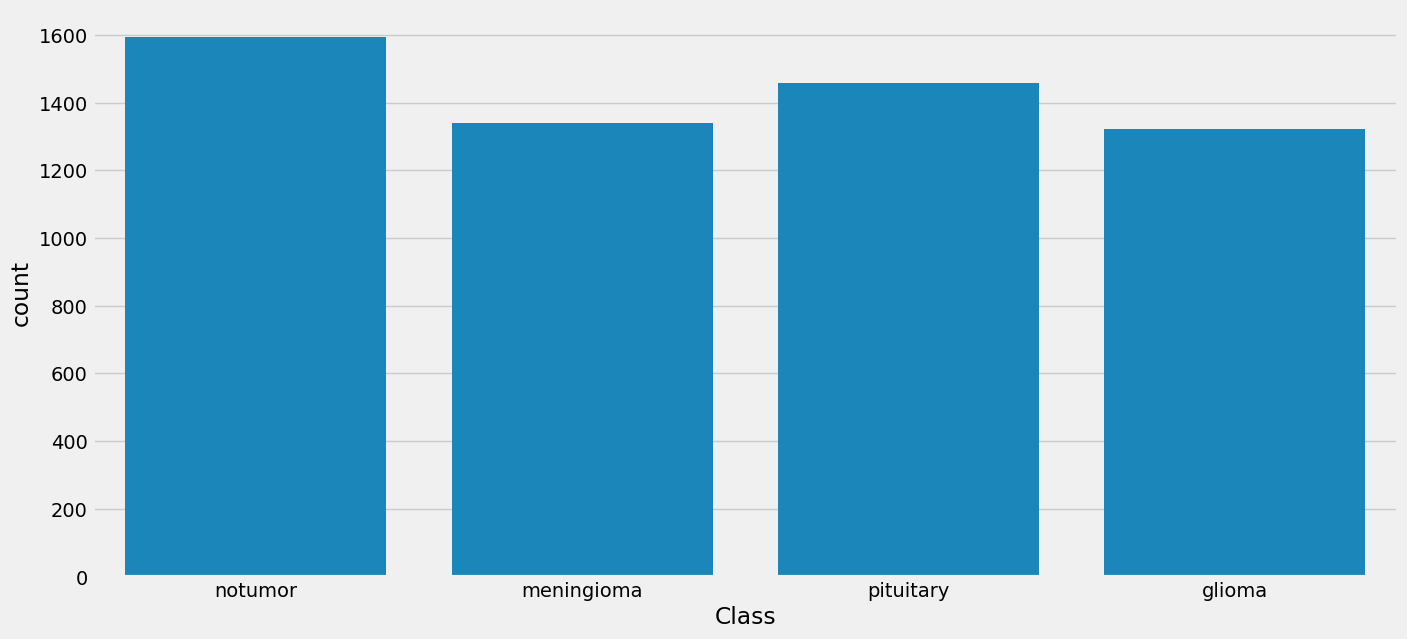

In [34]:
plt.figure(figsize = (15,7))
ax = sns.countplot(data = tr_df, x = tr_df['Class'])

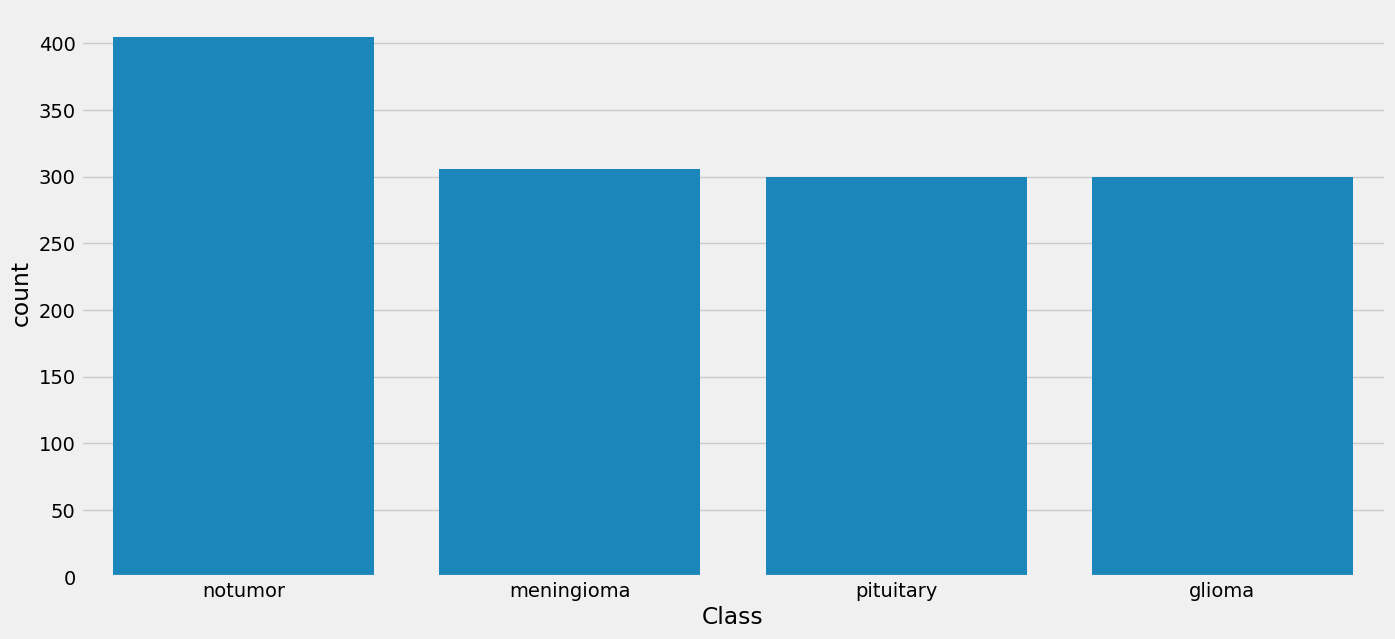

In [35]:
plt.figure(figsize = (15,7))
ax = sns.countplot(data = ts_df, x = ts_df['Class'])

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [38]:
batch_size = 32

image_size = (299,299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range = (0.8,1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [39]:
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col="Class Path",
                                             y_col = 'Class',
                                             batch_size = batch_size,
                                             target_size = image_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col="Class Path",
                                             y_col = 'Class',
                                             batch_size = batch_size,
                                             target_size = image_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                             y_col = 'Class',
                                             batch_size = 16,
                                             target_size = image_size, shuffle = False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


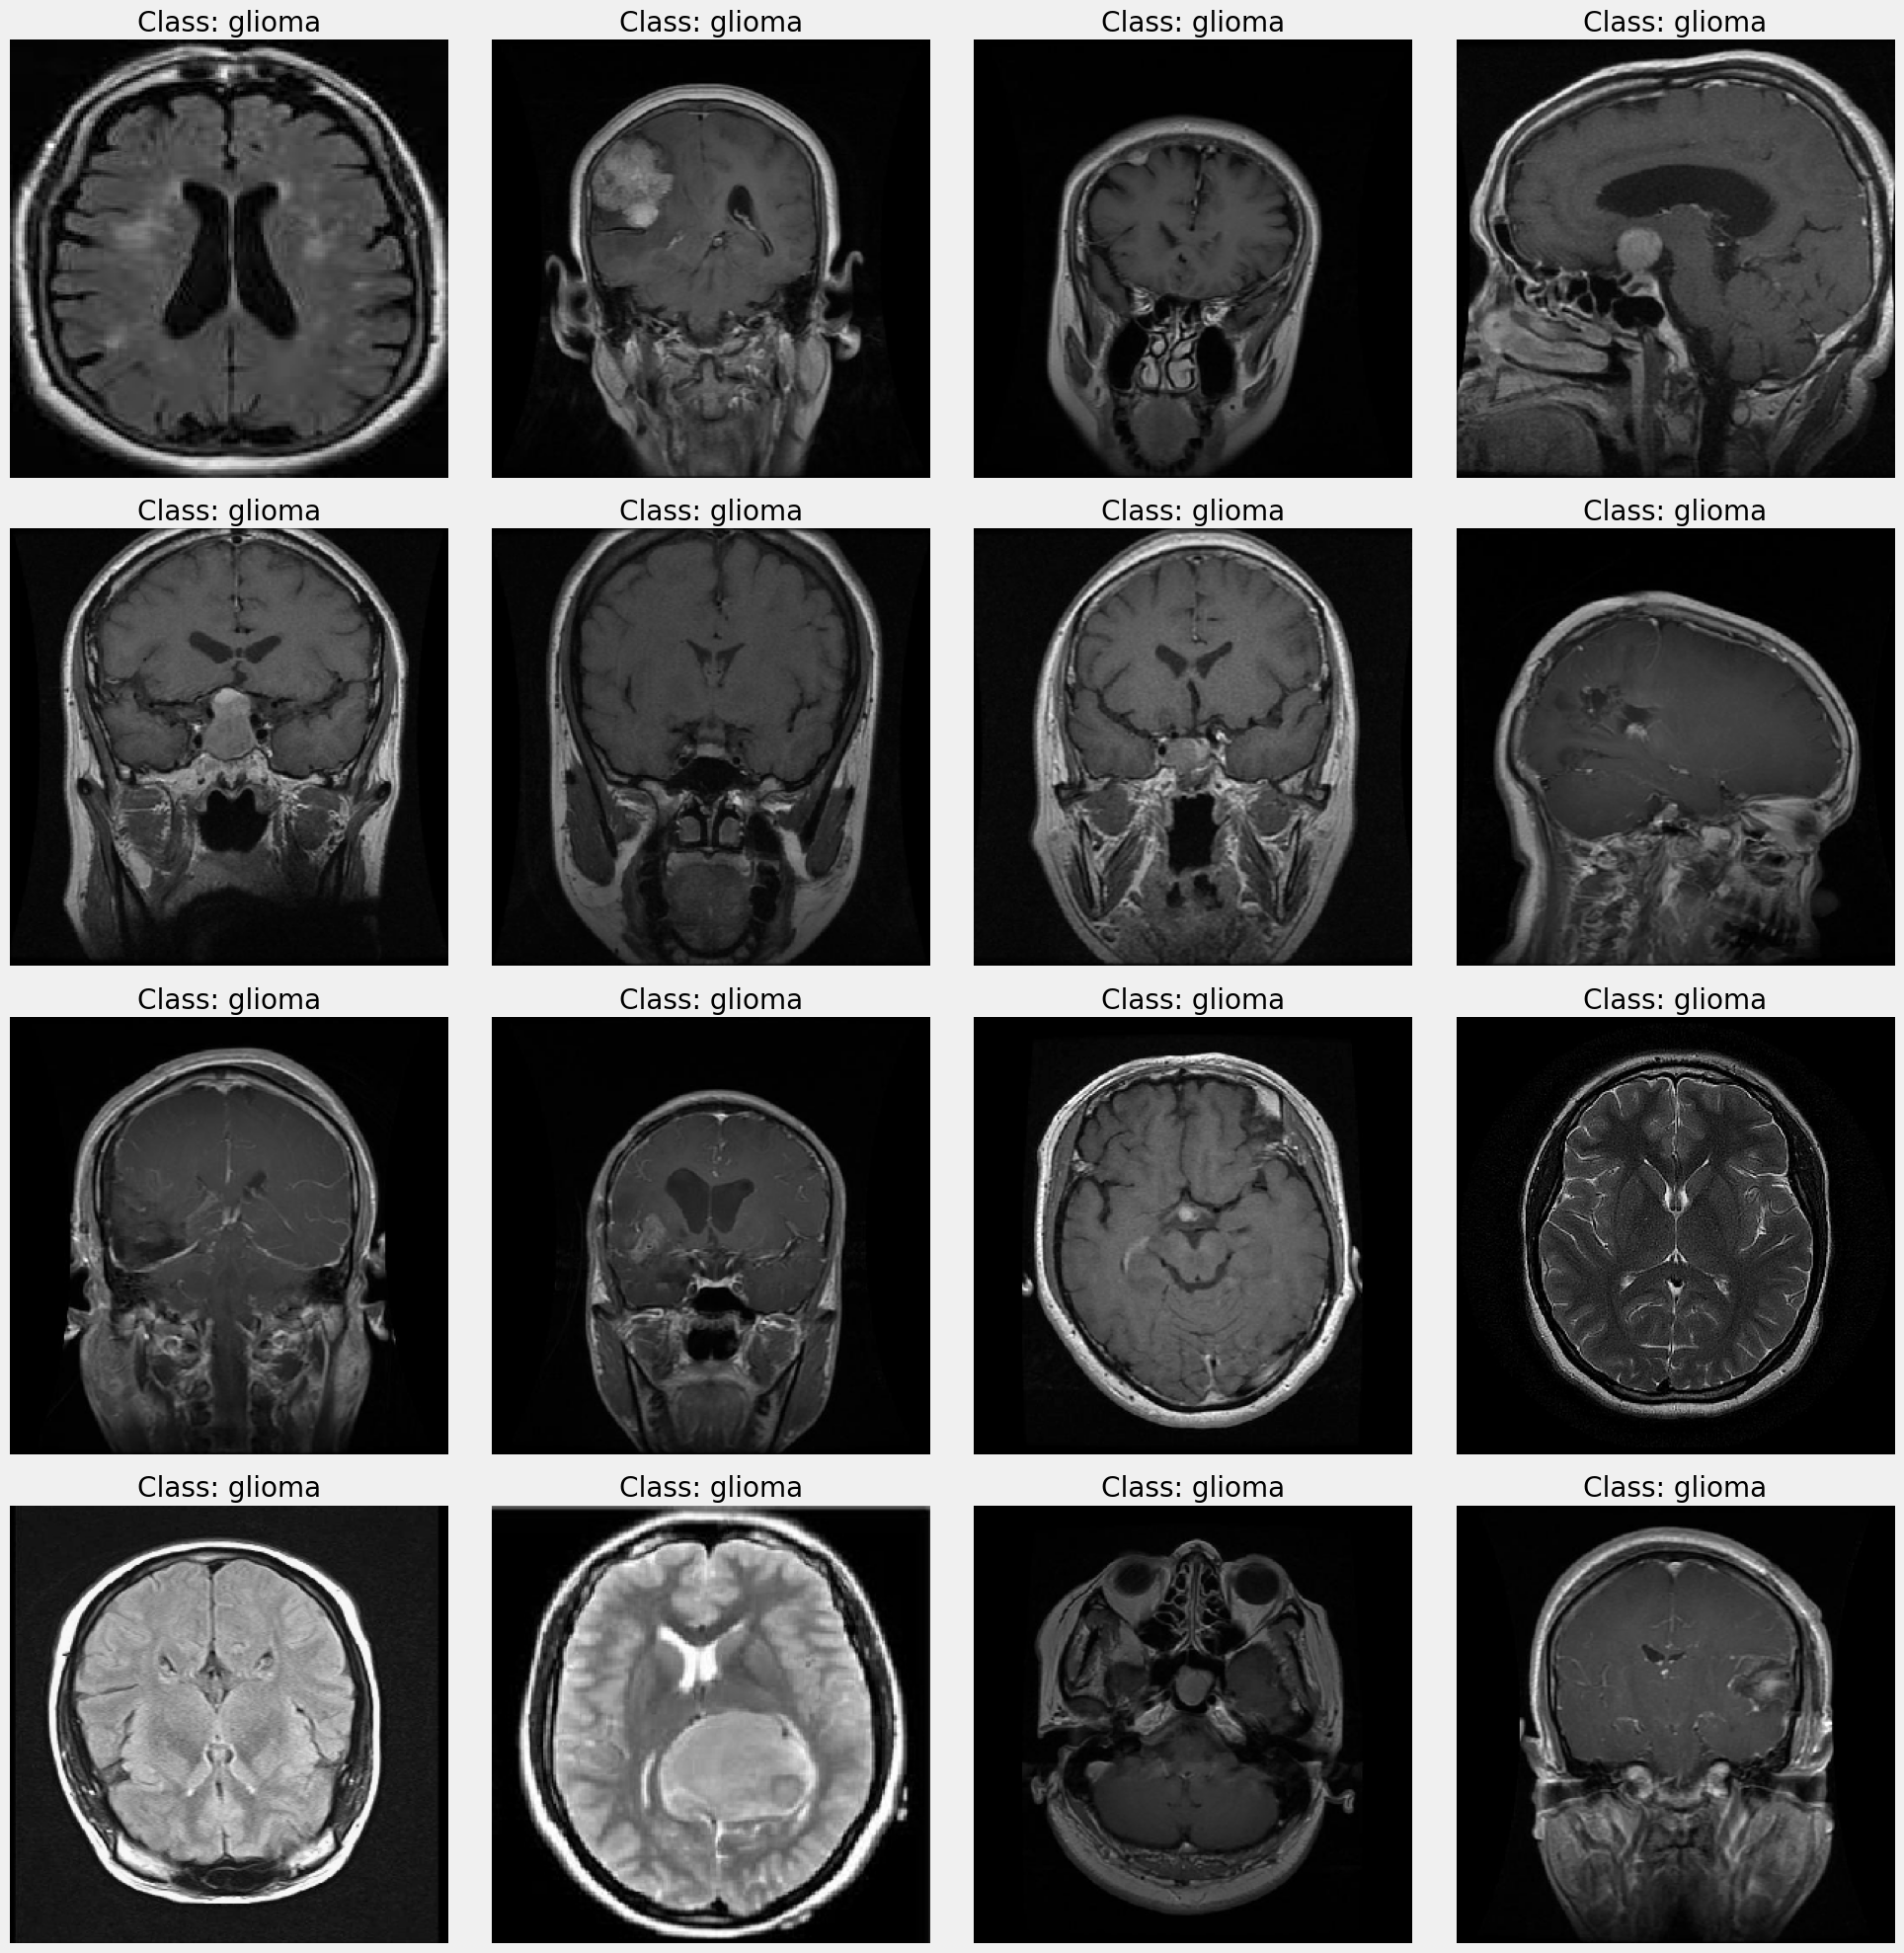

In [40]:
plt.figure(figsize = (20,20))
for i in range(16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = [1][0]
  plt.imshow(image)

  class_index = np.argmax(label)

  class_names = list(tr_gen.class_indices.keys())
  class_indicies = list(tr_gen.class_indices.values())

  index_position = class_indicies.index(class_index)

  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
image_shape = (299,299,3)

base_model = tf.keras.applications.Xception(include_top=False,weights="imagenet",input_shape=image_shape,pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128,activation = 'relu'),
    Dropout(rate = 0.25),
    Dense(4,activation = 'softmax')
])

In [47]:
model.compile(Adamax(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall()])

In [48]:
hist = model.fit(tr_gen, epochs = 5, validation_data = valid_gen)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 193s 848ms/step - accuracy: 0.9808 - loss: 0.0752 - precision_3: 0.9825 - recall_3: 0.9789 - val_accuracy: 0.9939 - val_loss: 0.0238 - val_precision_3: 0.9939 - val_recall_3: 0.9939
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 166s 745ms/step - accuracy: 0.9942 - loss: 0.0178 - precision_3: 0.9942 - recall_3: 0.9942 - val_accuracy: 0.9786 - val_loss: 0.0991 - val_precision_3: 0.9786 - val_recall_3: 0.9771
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 777ms/step - accuracy: 0.9998 - loss: 0.0023 - precision_3: 0.9998 - recall_3: 0.9998 - val_accuracy: 0.9954 - val_loss: 0.0237 - val_precision_3: 0.9954 - val_recall_3: 0.9954
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 746ms/step - accuracy: 0.9961 - loss: 0.0123 - precision_3: 0.9961 - recall_3: 0.9961 - val_accuracy: 0.9893 - val_loss: 0.0426 - val_precision_3: 0.9893 - val_recall_3: 0.9893
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 751ms/step - accuracy: 0.9948 - loss: 0.0146 - precision_3: 0.9956 - rec

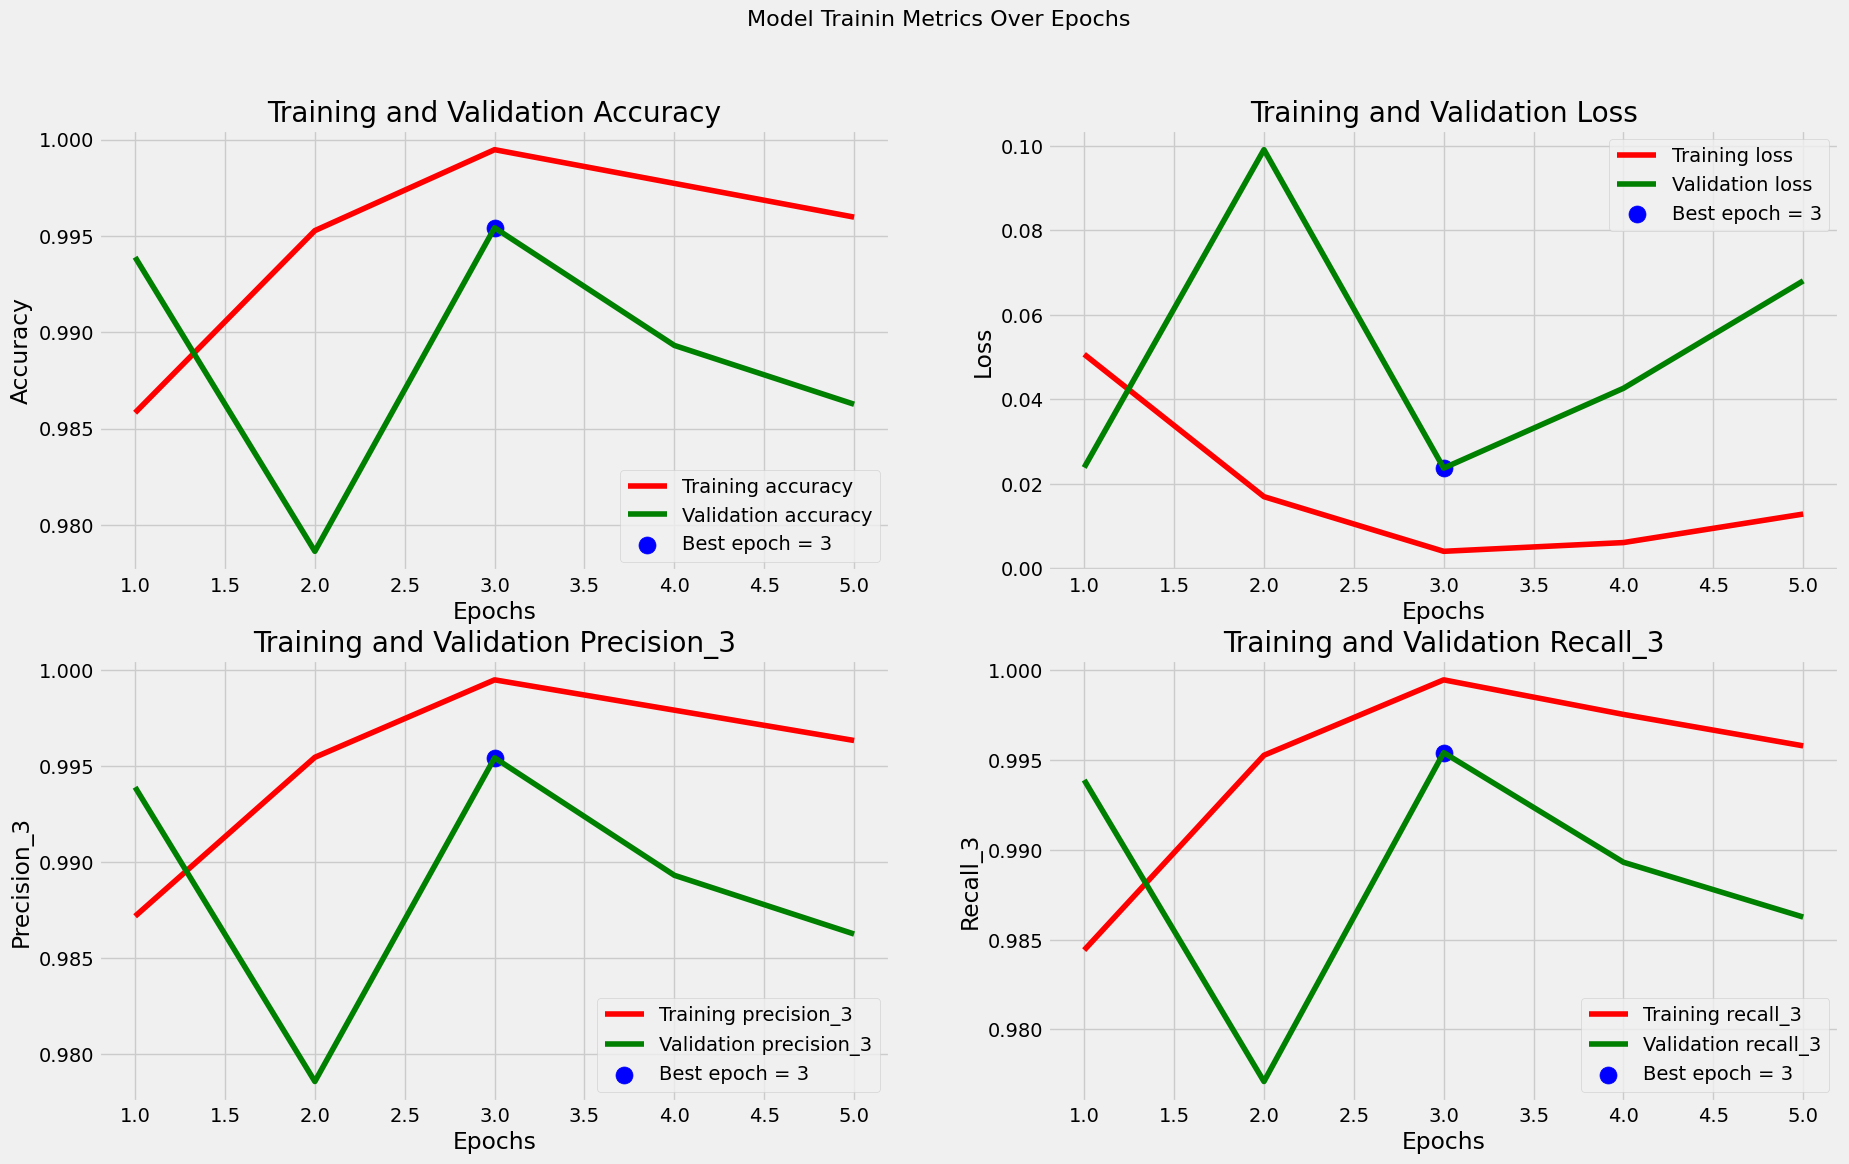

In [55]:
metrics  = ['accuracy', 'loss', 'precision_3', 'recall_3']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}

for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label = f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label = f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c = 'blue', label = f'Best epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)
plt.suptitle('Model Trainin Metrics Over Epochs', fontsize = 16)
plt.show()

In [56]:
train_score = model.evaluate(tr_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(ts_gen, verbose = 1)

print(f"Train Accuracy {train_score[1] * 100:.2f}%")
print(f"Train Loss {train_score[0]:.4f}%")
print(f"\n\nValidation Accuracy {valid_score[1] * 100:.2f}%")
print(f"Validation Loss {valid_score[0]:.4f}%")
print(f"\n\nTest Accuracy {test_score[1] * 100:.2f}%")
print(f"Test Loss {test_score[0]:.4f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.9981 - loss: 0.0049 - precision_3: 0.9981 - recall_3: 0.9981
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9887 - loss: 0.0446 - precision_3: 0.9887 - recall_3: 0.9887
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9375 - loss: 0.0618 - precision_3: 0.9375 - recall_3: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9783 - loss: 0.0673 - precision_3: 0.9783 - recall_3: 0.9783
Train Accuracy 99.77%
Train Loss 0.0073%


Validation Accuracy 98.47%
Validation Loss 0.0689%


Test Accuracy 98.63%
Test Loss 0.0586%


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step


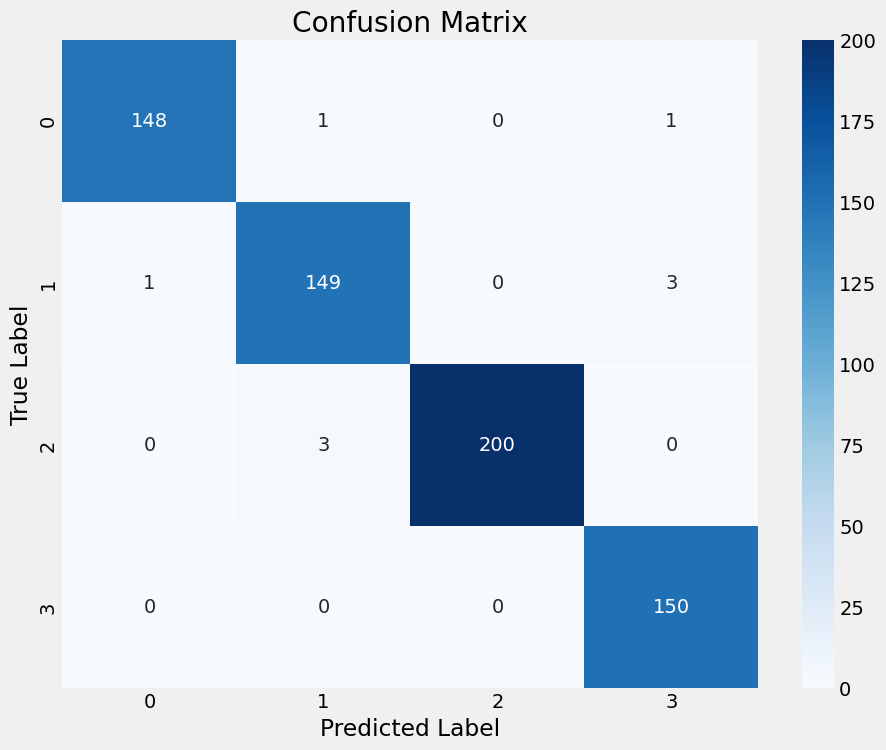

In [57]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds,axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize= (10,8))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [58]:
from PIL import Image
def predict(img_path: str) -> None:
  labels = list(class_dict.keys())
  plt.figure(figsize=(6,8))
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis = 0) / 255.0

  predictions = model.predict(img_array)
  probabilities = list(predictions[0])
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  plt.subplot(2,1,2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize = 15)
  plt.title("Class Probability")

  ax = plt.gca()
  ax.bar_label(bars, fmt="%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\n Predicted tumor type: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


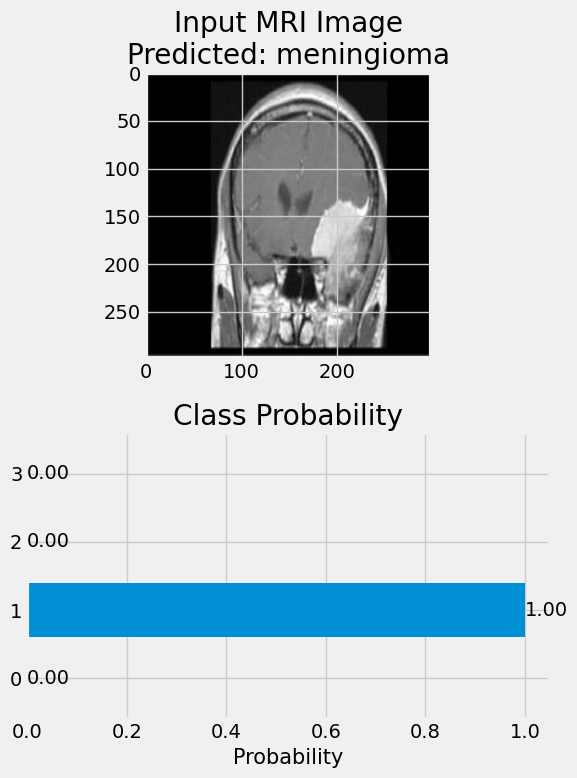


 Predicted tumor type: meningioma


In [59]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

In [91]:
model.save_weights("xception_model.weights.h5")

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [62]:
batch_size = 16

img_size = (299,299)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range = (0.8,1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df, x_col="Class Path",
                                             y_col = 'Class',
                                             batch_size = batch_size,
                                             target_size = image_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col="Class Path",
                                             y_col = 'Class',
                                             batch_size = batch_size,
                                             target_size = image_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                             y_col = 'Class',
                                             batch_size = 16,
                                             target_size = image_size, shuffle = False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [63]:
# Create a Sequential model
cnn_model = Sequential()

# Convolutional layers
# Changed input_shape to (299, 299, 3) to match ImageDataGenerator output
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(299, 299, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax'))  # Output layer with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Display the model summary
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 299, 299, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 149, 149, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 149, 149, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 74, 74, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 74, 74, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 37, 37, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,872,772 (26.22 MB)

 Trainable params: 6,872,772 (26.22 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = cnn_model.fit(tr_gen, epochs=5, validation_data=valid_gen)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 195s 532ms/step - accuracy: 0.5443 - loss: 2.4450 - precision_4: 0.6502 - recall_4: 0.3213 - val_accuracy: 0.6824 - val_loss: 1.0888 - val_precision_4: 0.7436 - val_recall_4: 0.6244
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 194s 518ms/step - accuracy: 0.7816 - loss: 0.8121 - precision_4: 0.8177 - recall_4: 0.7448 - val_accuracy: 0.8107 - val_loss: 0.6575 - val_precision_4: 0.8274 - val_recall_4: 0.7756
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 185s 518ms/step - accuracy: 0.8486 - loss: 0.5612 - precision_4: 0.8591 - recall_4: 0.8278 - val_accuracy: 0.8611 - val_loss: 0.5421 - val_precision_4: 0.8714 - val_recall_4: 0.8382
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 186s 519ms/step - accuracy: 0.8863 - loss: 0.4431 - precision_4: 0.8984 - recall_4: 0.8734 - val_accuracy: 0.8992 - val_loss: 0.4510 - val_precision_4: 0.9005 - val_recall_4: 0.8840
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 202s 520ms/step - accuracy: 0.9267 - loss: 0.3504 - precision_4: 0.9310 - recall_4: 0.9

In [65]:
! pip install streamlit pyngrok python-dotenv

In [93]:
cnn_model.save("cnn_model.h5")

In [66]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata


In [67]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [127]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [133]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from dotenv import load_dotenv
load_dotenv()

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def generate_saliency_map(model, img_array, class_index, img_size):
    """
    Creates a visual representation (saliency map) highlighting areas of a brain MRI image that are most important for the model's prediction. Thus, enhancing transparency and trust in the output.
    """

    # Compute gradients of the target class with respect to the input image
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]

    # Gradient processing
    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

    # Apply mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    # Save the original uploaded image
    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    # Define path and save the saliency map
    saliency_map_path = f'saliency_maps/{uploaded_file.name}'
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

def load_xception_model(model_path):
    img_shape = (299, 299, 3)
    base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                                input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation='relu'),
        Dropout(rate=0.25),
        Dense(4, activation='softmax')
    ])
    model.build((None,) + img_shape)

    # Compile the model
    model.compile(Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           Precision(),
                           Recall()])

    model.load_weights(model_path)
    return model

st.title("Brain Tumor Classification")

st.write("Upload an image of a Brain MRI to classify")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Convert the file to an opencv image
    selected_model = st.radio(
        "Select Model",
        ("Transfer Learning - Xception", "Custom Convolutional Neural Network")
    )
    if selected_model == "Transfer Learning - Xception":
      model = load_xception_model("/content/xception_model.weights.h5")
      image_size = (299,299)
    else:
      model = load_model("/content/cnn_model.h5")
      image_size = (224,224)
    labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    img = image.load_img(uploaded_file, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    result = labels[class_index]
    st.write(f"Prediction: {result}")
    for label, prob in zip(labels, prediction[0]):
      st.write(f"{label}: {prob:.4f}%")

    saliency_map = generate_saliency_map(model, img_array, class_index, image_size)
    col1, col2 = st.columns(2)
    with col1:
      st.image(uploaded_file, caption="Uploaded Image", use_container_width = True)
    with col2:
      st.image(saliency_map, caption="Saliency Map", use_container_width = True)

Overwriting app.py


In [128]:
thread = Thread(target=run_streamlit)
thread.start()

In [135]:
public_url = ngrok.connect(addr=8501)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://9bd7-34-142-222-140.ngrok-free.app" -> "http://localhost:8501"


In [134]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://5082-34-142-222-140.ngrok-free.app -> http://localhost:8501
